In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm  # For displaying progress bars
from datasets import load_dataset  # For loading datasets
from sklearn.model_selection import train_test_split  # For splitting the dataset
from transformers import BertTokenizer  # For tokenizing text
from torch.utils.data import TensorDataset  # For creating Tensor datasets
import time  # For measuring time
from sklearn.metrics import accuracy_score, precision_score, f1_score  # For evaluation metrics
from sklearn.exceptions import UndefinedMetricWarning  # For handling metric warnings
import matplotlib.pyplot as plt  # For plotting
from tabulate import tabulate  # For tabular data formatting
import random  # For randomization
import numpy as np  # For numerical operations
from transformers import (
    BertTokenizer,  # Tokenizer for BERT models
    AdamW,  # Optimizer for BERT models
    get_linear_schedule_with_warmup,  # Learning rate scheduler for BERT models
    BertConfig,  # Configuration for BERT models
    BertForSequenceClassification  # BERT model for sequence classification tasks
)
from torch.utils.data import (
    DataLoader,  # Data loader for creating batches
    RandomSampler,  # Sampler for random sampling of data
    SequentialSampler  # Sampler for sequential sampling of data
)
from sklearn.metrics import f1_score  # For computing the F1 score
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
# 1. Torch: PyTorch library for deep learning
# 2. Pandas: Library for data manipulation and analysis
# 3. tqdm: Library for displaying progress bars
# 4. datasets: Library for working with datasets
# 5. train_test_split: Function for splitting the dataset into training and validation sets
# 6. BertTokenizer: Tokenizer for BERT models
# 7. TensorDataset: Dataset class for creating PyTorch Tensor datasets
# 8. time: Module for measuring time
# 9. accuracy_score, precision_score, f1_score: Evaluation metrics for classification tasks
# 10. UndefinedMetricWarning: Warning for undefined metric values
# 11. matplotlib.pyplot: Plotting library
# 12. tabulate: Library for formatting tabular data
# 13. random: Module for randomization
# 14. numpy: Library for numerical operations
# 15. AdamW: Optimizer for BERT models
# 16. get_linear_schedule_with_warmup: Learning rate scheduler for BERT models
# 17. BertConfig: Configuration for BERT models
# 18. BertForSequenceClassification: BERT model for sequence classification tasks
# 19. DataLoader: Data loader for creating batches
# 20. RandomSampler: Sampler for random sampling of data
# 21. SequentialSampler: Sampler for sequential sampling of data
# 22. f1_score: Function for computing the F1 score

2023-07-31 17:26:19.429256: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-31 17:26:19.850270: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 17:26:21.835282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def count_words(text):
    words = word_tokenize(text)
    return len(words)

def datacleaning_amazon():
    dataset = load_dataset("amazon_us_reviews", "Apparel_v1_00")
    train_data = dataset['train']

    train_data = train_data.select(range(50000))

    # Filter rows with review_body length less than or equal to 256 words
    train_data = train_data.filter(lambda example: count_words(example['review_body']) <= 256)

    # Limit the dataset to the first 10,000 rows
    train_data = train_data.select(range(10000))

    df = train_data.to_pandas()  # Convert the dataset to a Pandas DataFrame
    df = df[['customer_id', 'review_headline', 'review_body', 'star_rating']]  # Select specific columns
    df.columns = ['customer_id', 'review_headline', 'review_body', 'star_rating']  # Rename the selected columns
    df.set_index('customer_id', inplace=True)

    df['sentiment'] = df['star_rating'].map({5: 'good', 4: 'good', 3: 'neutral', 2: 'bad', 1: 'bad'})

    possible_labels = df.sentiment.unique()  # Get unique category labels from the DataFrame column 'category'

    label_dict = {}  # Create a dictionary to map each possible label to a unique index
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df['label'] = df.sentiment.replace(label_dict)

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=0.15,
        random_state=17,
        stratify=df.label.values
    )

    df['data_type'] = ['not_set'] * df.shape[0]  # Set a new column 'data_type' for later data split

    # Set the 'data_type' column of the dataframe for training and validation data
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'

    return df

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

def accuracy_per_class(preds, labels, label_dict):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Initialize the confusion matrix.
    num_classes = len(label_dict)
    confusion_mat = confusion_matrix(labels_flat, preds_flat, labels=list(range(num_classes)))
    
    # Calculate accuracy and F1 score per class
    accuracies = {}
    f1_scores = {}
    for label in range(num_classes):
        # Calculate accuracy for this class
        num_correct = confusion_mat[label, label]
        num_instances = np.sum(confusion_mat[label, :])
        accuracy = num_correct / num_instances * 100
        accuracies[label] = accuracy
        
        # Calculate F1 score for this class
        f1 = f1_score(labels_flat, preds_flat, labels=[label], average='weighted')
        f1_scores[label] = f1

        # Print the class name, accuracy numerator, and denominator.
        class_name = label_dict_inverse[label]
        print(f'Class: {class_name}')
        print(f'Accuracy: {num_correct}/{num_instances} ({accuracy:.2f}%)')
        print(f'F1 Score: {f1:.2f}\n')

    # Calculate total accuracy and F1 score
    total_accuracy = accuracy_score(labels_flat, preds_flat) * 100
    total_f1_score = f1_score(labels_flat, preds_flat, average='weighted')

    # Print the total accuracy and F1 score
    print(f'Total Accuracy: {total_accuracy:.2f}%')
    print(f'Total F1 Score: {total_f1_score:.2f}')


#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals

def train_model(trainer, dataloader_train, dataloader_val, epochs, patience):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_gpt_amazon_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                tqdm.write('\nEarly stopping triggered. Training stopped.')
                break
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create the x-axis values based on the actual number of epochs completed
    x_values = range(1, len(training_loss_list) + 1)
    
    # Create the metrics subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(x_values, training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(x_values, validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(x_values, f1_score_list, label='F1 Score')

    # Plot Accuracy
    ax.plot(x_values, accuracy_list, label='Accuracy')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()
    
    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, len(training_loss_list) + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if accuracy_list[epoch - 1] > previous_results['val_f1']:
                row[4] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if accuracy_list[epoch - 1] < previous_results['val_f1']:
                row[4] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if precision_list[epoch - 1] > previous_results['val_f1']:
                row[5] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if precision_list[epoch - 1] < previous_results['val_f1']:
                row[5] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

    return training_loss_list, validation_loss_list, accuracy_list, precision_list, f1_score_list

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
df = datacleaning_amazon()

Found cached dataset amazon_us_reviews (/home/z123010/.cache/huggingface/datasets/amazon_us_reviews/Apparel_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/z123010/.cache/huggingface/datasets/amazon_us_reviews/Apparel_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563/cache-39524de3311549b5.arrow


In [4]:
# Create label_dict and assign the number of labels
label_dict = {label: index for index, label in enumerate(df['label'].unique())}

In [5]:
df.sample(n=10, random_state=42)  # Generate 10 random rows from df

,review_headline,review_body,star_rating,sentiment,label,data_type
customer_id,,,,,,
50867430,Absolutely must,Fits great! Feels comfortable! An overall grea...,5,good,0,train
14094716,Five Stars,Item is ok,5,good,0,val
36322626,Two Stars,This shirt runs extremely small. I generally ...,2,bad,2,train
16521558,Five Stars,Love it,5,good,0,train
28567406,Five Stars,Great for computer backups.,5,good,0,train
28796755,Five Stars,"Great fit, very comfortable!",5,good,0,train
159429,Runs Very Small,The product looks like the picture and the fab...,4,good,0,train
117231,Five Stars,"I luv it,",5,good,0,train
1965478,Ugh.,"I bought this design and one other, both XXL, ...",1,bad,2,val


[nltk_data] Downloading package punkt to /home/z123010/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


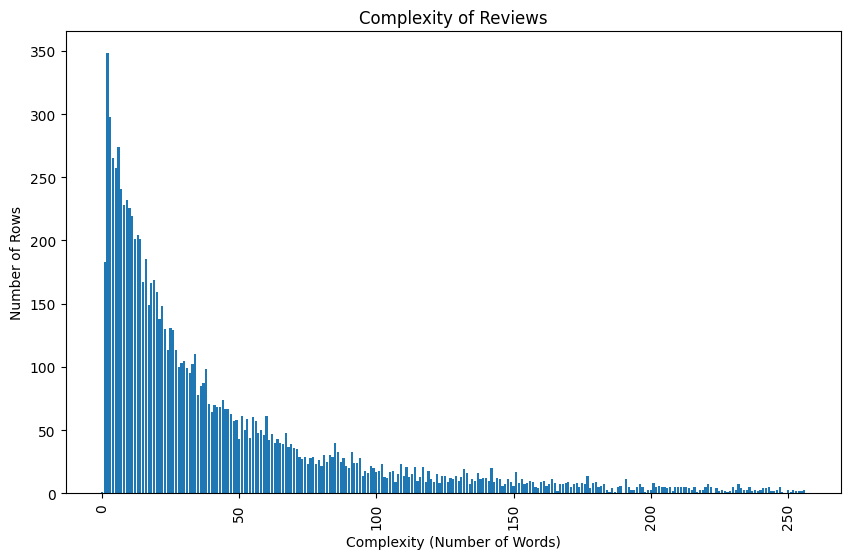

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize

# Download the punkt tokenizer (if not already downloaded)
nltk.download('punkt')

# Function to count the number of words in a given text
def count_words(text):
    words = word_tokenize(text)
    return len(words)

# Apply the count_words function to each row of the review_body column
df['word_count'] = df['review_body'].apply(count_words)

# Group by the word_count and count how many rows have reviews of that length
word_count_df = df['word_count'].value_counts().reset_index()
word_count_df.columns = ['Complexity (Number of Words)', 'Number of Rows']

# Sort the DataFrame by the complexity (number of words) in ascending order
word_count_df.sort_values(by='Complexity (Number of Words)', inplace=True)

# Create a bar plot to visualize the complexity and the number of rows
plt.figure(figsize=(10, 6))
plt.bar(word_count_df['Complexity (Number of Words)'], word_count_df['Number of Rows'])
plt.xlabel('Complexity (Number of Words)')
plt.ylabel('Number of Rows')
plt.title('Complexity of Reviews')
plt.xticks(rotation=90)
plt.show()


In [7]:
df.groupby(['star_rating', 'label', 'data_type']).count()

review_headline  review_body  sentiment   
star_rating label data_type                                            
1           2     train                  907          907        907  \
                  val                    190          190        190   
2           2     train                  490          490        490   
                  val                     83           83         83   
3           1     train                  683          683        683   
                  val                    135          135        135   
4           0     train                 1330         1330       1330   
                  val                    261          261        261   
5           0     train                 4665         4665       4665   
                  val                   1256         1256       1256   

                             word_count  
star_rating label data_type              
1           2     train             907  
                  val               190  
2           2     train             490  
                  val                83  
3           1     train             683  
                  val               135  
4           0     train            1330  
                  val               261  
5           0     train            4665  
                  val              1256

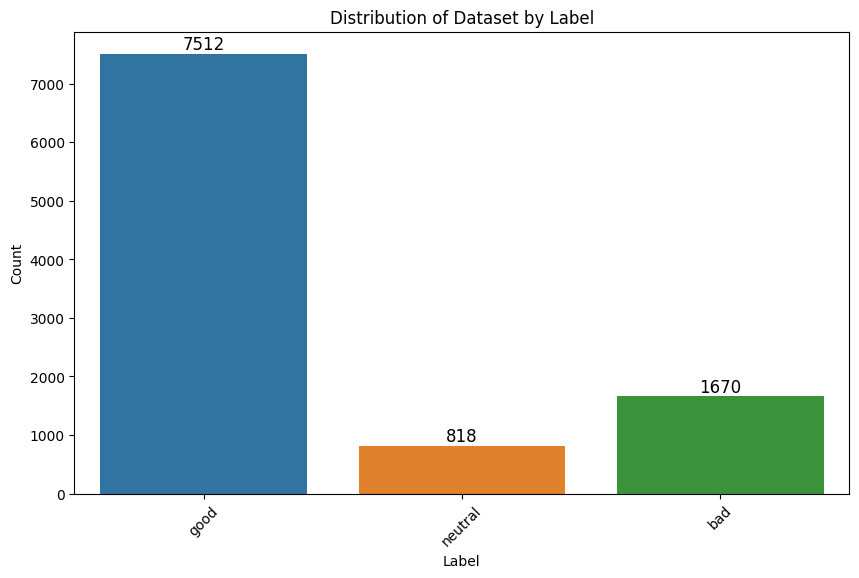

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the data already grouped as mentioned in your initial code
grouped_data = df.groupby(['label']).count()

# Reset the index to access the 'label' and 'data_type' columns
grouped_data.reset_index(inplace=True)

# Map numeric labels to text labels
label_mapping = {0: 'good', 1: 'neutral', 2: 'bad'}
grouped_data['label'] = grouped_data['label'].map(label_mapping)

# Create a bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='data_type', data=grouped_data)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Dataset by Label')

# Add count numbers as annotations to each bar
for index, row in grouped_data.iterrows():
    count = row['data_type']
    plt.text(index, count, str(count), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45)
plt.show()


In [9]:
# Load BERT tokenizer
pretrained_path = 'gpt2'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

encoded_data_train_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_train_body = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_train_headline = encoded_data_train_headline['input_ids']
attention_masks_train_headline = encoded_data_train_headline['attention_mask']

input_ids_train_body = encoded_data_train_body['input_ids']
attention_masks_train_body = encoded_data_train_body['attention_mask']

input_ids_train = torch.cat((input_ids_train_headline, input_ids_train_body), dim=1)
attention_masks_train = torch.cat((attention_masks_train_headline, attention_masks_train_body), dim=1)

labels_train = torch.tensor(df[df.data_type=='train'].label.values)


encoded_data_val_headline = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_headline.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

encoded_data_val_body = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].review_body.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_val_headline = encoded_data_val_headline['input_ids']
attention_masks_val_headline = encoded_data_val_headline['attention_mask']

input_ids_val_body = encoded_data_val_body['input_ids']
attention_masks_val_body = encoded_data_val_body['attention_mask']

input_ids_val = torch.cat((input_ids_val_headline, input_ids_val_body), dim=1)
attention_masks_val = torch.cat((attention_masks_val_headline, attention_masks_val_body), dim=1)

labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [10]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(8075, 1925)

In [11]:
from transformers import GPT2Model, GPT2Config

num_classes = 3

class SentimentModel(nn.Module):
    def __init__(self, pretrained_gpt_path, num_classes, lstm_hidden_size):
        super(SentimentModel, self).__init__()

        gpt_config = GPT2Config.from_pretrained(            
            pretrained_gpt_path,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.3)
        self.gpt = GPT2Model.from_pretrained(pretrained_gpt_path, config=gpt_config)

        self.dropout = nn.Dropout(0.2)
        self.lstm = nn.LSTM(gpt_config.hidden_size, lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        gpt_outputs = self.gpt(input_ids, attention_mask=attention_mask)[0]
        gpt_last_hidden_state = self.dropout(gpt_outputs[:, -1, :])  # Use the last hidden state
        
        output = torch.cat((gpt_last_hidden_state,), dim=1)

        # Pass the pooled output through the LSTM layer
        lstm_output, _ = self.lstm(output.unsqueeze(0))
        lstm_output = lstm_output.squeeze(0)

        logits = self.fc(lstm_output)
        outputs = nn.functional.softmax(logits, dim=1)

        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs

In [12]:
# Create model instance
pretrained_path = "gpt2"
lstm_hidden_size = 256
model = SentimentModel(pretrained_path, num_classes, lstm_hidden_size)

In [13]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (gpt): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(768, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [14]:
# Count total params, trainable params, and non-trainable params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

# Print the results
print(f"Total Params: {total_params}")
print(f"Trainable Params: {trainable_params}")
print(f"Non-trainable Params: {non_trainable_params}")

Total Params: 125491203
Trainable Params: 125491203
Non-trainable Params: 0


In [15]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
)

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Set the batch size and create data loaders for training and validation sets

batch_size = 8 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Define the optimizer
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8,
    weight_decay=0.01

)


epochs = 10
patience = 3
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda



Fold 1


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6396813016513935
Validation loss: 0.49433454137184835
F1 Score (weighted): 0.7827674578696512


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.45151214636770065
Validation loss: 0.39653364102365357
F1 Score (weighted): 0.8490816558345499
29.42% Training loss decreased compared to the previous epoch
19.78% Validation loss decreased compared to the previous epoch
8.47% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.3829441157695238
Validation loss: 0.40026913906475253
F1 Score (weighted): 0.8543417948514399
15.19% Training loss decreased compared to the previous epoch
0.94% Validation loss increased compared to the previous epoch
0.62% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.34071735369438066
Validation loss: 0.4370878263293664
F1 Score (weighted): 0.8583789178164449
11.03% Training loss decreased compared to the previous epoch
9.2% Validation loss increased compared to the previous epoch
0.47% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.31220342434878173
Validation loss: 0.41017478242249106
F1 Score (weighted): 0.8614120845451734
8.37% Training loss decreased compared to the previous epoch
6.16% Validation loss decreased compared to the previous epoch
0.35% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 20.96947441895803 minutes
Final Accuracy: 0.8730650154798761
Final Precision: 0.8742528879570943


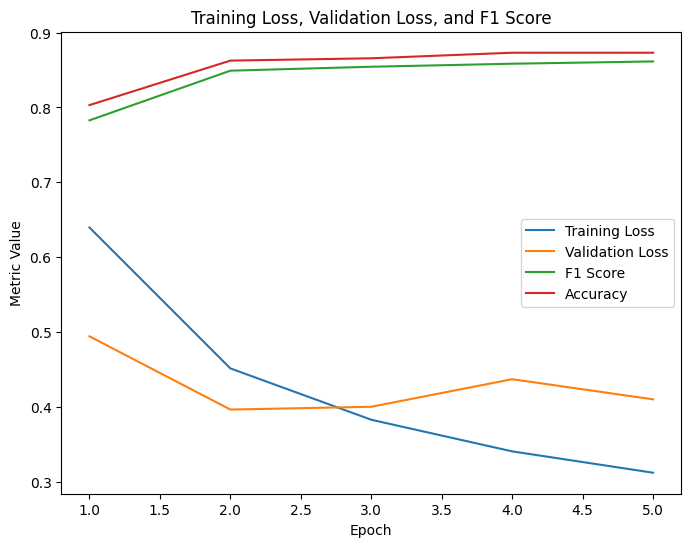

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.6396813016513935   0.49433454137184835  0.7827674578696512  0.8030959752321981     0.86245
2                     0.45151214636770065  0.39653364102365357  0.8490816558345499  0.8490816558345499     0.849082
3                     0.3829441157695238   0.40026913906475253  0.8543417948514399  0.8543417948514399     0.854342
4                     0.34071735369438066  0.4370878263293664   0.8583789178164449  0.8583789178164449     0.858379
5                     0.31220342434878173  0.41017478242249106  0.8614120845451734  0.8614120845451734     0.861412
Total Training Time                                                                                     1258.17
Final Precision                                                              

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.31763986294102475
Validation loss: 0.2556482607401944
F1 Score (weighted): 0.911859853551992


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.30181710126159694
Validation loss: 0.2594616191973449
F1 Score (weighted): 0.9096337439451255
4.98% Training loss decreased compared to the previous epoch
1.49% Validation loss increased compared to the previous epoch
0.24% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.2784837196767791
Validation loss: 0.25814208632685465
F1 Score (weighted): 0.908166349325028
7.73% Training loss decreased compared to the previous epoch
0.51% Validation loss decreased compared to the previous epoch
0.16% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2560891807695971
Validation loss: 0.25656264958013364
F1 Score (weighted): 0.9157020731572076
8.04% Training loss decreased compared to the previous epoch
0.61% Validation loss decreased compared to the previous epoch
0.83% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 16.755095632870994 minutes
Final Accuracy: 0.9195046439628483
Final Precision: 0.917965016519249


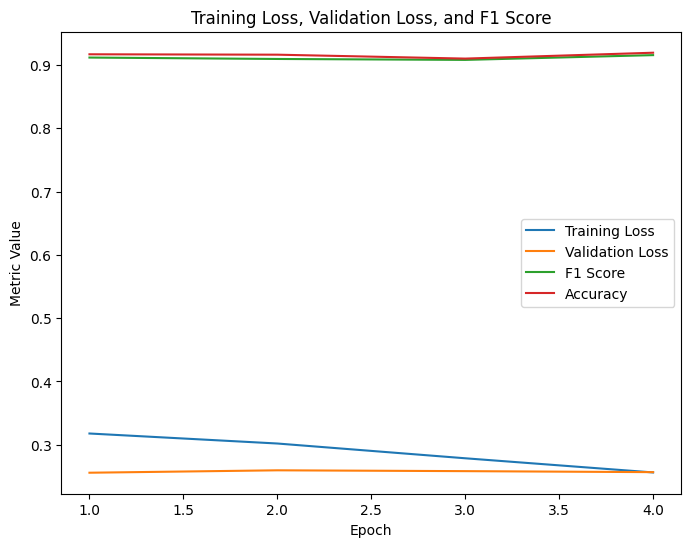

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.31763986294102475  0.2556482607401944   0.911859853551992   0.9170278637770898     0.916298
2                     0.30181710126159694  0.2594616191973449   0.9096337439451255  0.9096337439451255     0.909634
3                     0.2784837196767791   0.25814208632685465  0.908166349325028   0.908166349325028      0.908166
4                     0.2560891807695971   0.25656264958013364  0.9157020731572076  0.9157020731572076     0.915702
Total Training Time                                                                                     1005.31
Final Precision                                                                                            0.917965
Total Time (minutes)                                                        

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.2647563943669366
Validation loss: 0.16920065851928207
F1 Score (weighted): 0.9441880535528445


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.25245136075530955
Validation loss: 0.16818777781030586
F1 Score (weighted): 0.9481372033666077
4.65% Training loss decreased compared to the previous epoch
0.6% Validation loss decreased compared to the previous epoch
0.42% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.24662876370222317
Validation loss: 0.17226098811871712
F1 Score (weighted): 0.9424616688749695
2.31% Training loss decreased compared to the previous epoch
2.42% Validation loss increased compared to the previous epoch
0.6% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2398560107135246
Validation loss: 0.16549462440313015
F1 Score (weighted): 0.947738517649985
2.75% Training loss decreased compared to the previous epoch
3.93% Validation loss decreased compared to the previous epoch
0.56% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.2323410139352286
Validation loss: 0.16207171530960737
F1 Score (weighted): 0.9471684255805112
3.13% Training loss decreased compared to the previous epoch
2.07% Validation loss decreased compared to the previous epoch
0.06% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.23012770388862072
Validation loss: 0.16450499804427682
F1 Score (weighted): 0.9492526043051687
0.95% Training loss decreased compared to the previous epoch
1.5% Validation loss increased compared to the previous epoch
0.22% F1 Score increased compared to the previous epoch


Epoch 7:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.23324345891066542
Validation loss: 0.16218914304477264
F1 Score (weighted): 0.947892519986015
1.35% Training loss increased compared to the previous epoch
1.41% Validation loss decreased compared to the previous epoch
0.14% F1 Score decreased compared to the previous epoch


Epoch 8:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.23518114896764342
Validation loss: 0.1652495087802152
F1 Score (weighted): 0.9478853864200621
0.83% Training loss increased compared to the previous epoch
1.89% Validation loss increased compared to the previous epoch
0.0% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 33.55444048643112 minutes
Final Accuracy: 0.9504643962848297
Final Precision: 0.9480120299397872


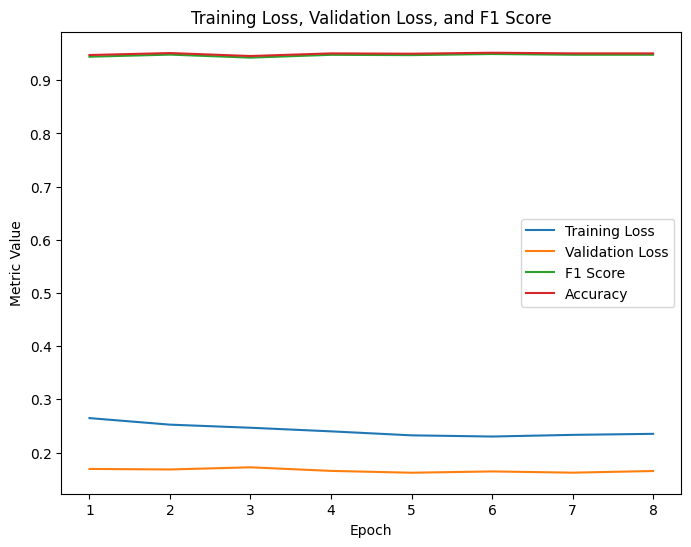

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.2647563943669366   0.16920065851928207  0.9441880535528445  0.9473684210526315     0.945489
2                     0.25245136075530955  0.16818777781030586  0.9481372033666077  0.9481372033666077     0.948137
3                     0.24662876370222317  0.17226098811871712  0.9424616688749695  0.9424616688749695     0.942462
4                     0.2398560107135246   0.16549462440313015  0.947738517649985   0.947738517649985      0.947739
5                     0.2323410139352286   0.16207171530960737  0.9471684255805112  0.9471684255805112     0.947168
6                     0.23012770388862072  0.16450499804427682  0.9492526043051687  0.9492526043051687     0.949253
7                     0.23324345891066542  0.16218914304477264  0.947892

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.23207271763493564
Validation loss: 0.15421391812863178
F1 Score (weighted): 0.9470813389364416


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.23222673942864006
Validation loss: 0.1516238408898566
F1 Score (weighted): 0.9471563331441777
0.07% Training loss increased compared to the previous epoch
1.68% Validation loss decreased compared to the previous epoch
0.01% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.22888580643621476
Validation loss: 0.15551150438034594
F1 Score (weighted): 0.9458126989759528
1.44% Training loss decreased compared to the previous epoch
2.56% Validation loss increased compared to the previous epoch
0.14% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.23101623805693933
Validation loss: 0.15150591801612243
F1 Score (weighted): 0.9450372269965875
0.93% Training loss increased compared to the previous epoch
2.58% Validation loss decreased compared to the previous epoch
0.08% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.22758454129348812
Validation loss: 0.15603846912779432
F1 Score (weighted): 0.9443002046998772
1.49% Training loss decreased compared to the previous epoch
2.99% Validation loss increased compared to the previous epoch
0.08% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.23337136040958067
Validation loss: 0.1560319906773765
F1 Score (weighted): 0.9436016256731248
2.54% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch
0.07% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.22779080761846682
Validation loss: 0.15512614048980544
F1 Score (weighted): 0.9443704439711714
2.39% Training loss decreased compared to the previous epoch
0.58% Validation loss decreased compared to the previous epoch
0.08% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 29.344970258076987 minutes
Final Accuracy: 0.9467492260061919
Final Precision: 0.9442370618929224


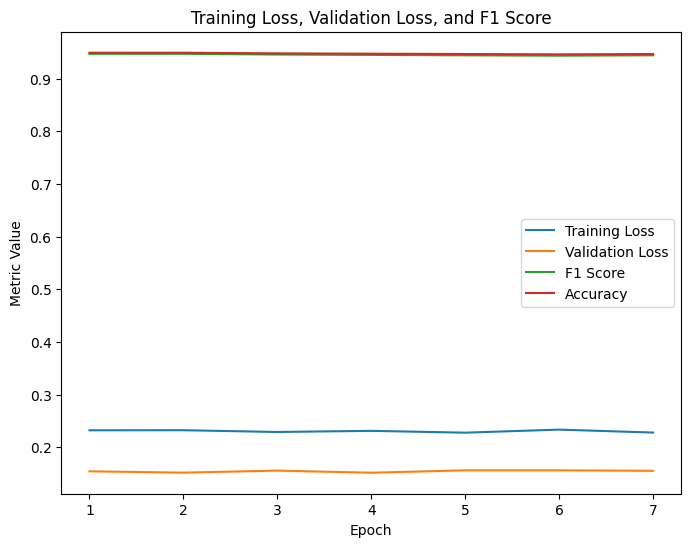

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.23207271763493564  0.15421391812863178  0.9470813389364416  0.9492260061919504     0.946989
2                     0.23222673942864006  0.1516238408898566   0.9471563331441777  0.9471563331441777     0.947156
3                     0.22888580643621476  0.15551150438034594  0.9458126989759528  0.9458126989759528     0.945813
4                     0.23101623805693933  0.15150591801612243  0.9450372269965875  0.9450372269965875     0.945037
5                     0.22758454129348812  0.15603846912779432  0.9443002046998772  0.9443002046998772     0.9443
6                     0.23337136040958067  0.1560319906773765   0.9436016256731248  0.9436016256731248     0.943602
7                     0.22779080761846682  0.15512614048980544  0.94437044

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.228908228568357
Validation loss: 0.18783799718401514
F1 Score (weighted): 0.9363417905293909


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.22861927661913364
Validation loss: 0.18903799159314003
F1 Score (weighted): 0.9357528520308592
0.13% Training loss decreased compared to the previous epoch
0.64% Validation loss increased compared to the previous epoch
0.06% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.22800015765305673
Validation loss: 0.1870604576047344
F1 Score (weighted): 0.9375477249225812
0.27% Training loss decreased compared to the previous epoch
1.05% Validation loss decreased compared to the previous epoch
0.19% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.22822094448936622
Validation loss: 0.1845243766438216
F1 Score (weighted): 0.9384659761470147
0.1% Training loss increased compared to the previous epoch
1.36% Validation loss decreased compared to the previous epoch
0.1% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.22273616955009298
Validation loss: 0.18492728224517502
F1 Score (weighted): 0.9374366866505746
2.4% Training loss decreased compared to the previous epoch
0.22% Validation loss increased compared to the previous epoch
0.11% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.22415123874463352
Validation loss: 0.1859513771706399
F1 Score (weighted): 0.9392402531624541
0.64% Training loss increased compared to the previous epoch
0.55% Validation loss increased compared to the previous epoch
0.19% F1 Score increased compared to the previous epoch


Epoch 7:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.22436217071389375
Validation loss: 0.1864571754940518
F1 Score (weighted): 0.9385195518546499
0.09% Training loss increased compared to the previous epoch
0.27% Validation loss increased compared to the previous epoch
0.08% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 29.349145523707072 minutes
Final Accuracy: 0.9411764705882353
Final Precision: 0.9397157927498485


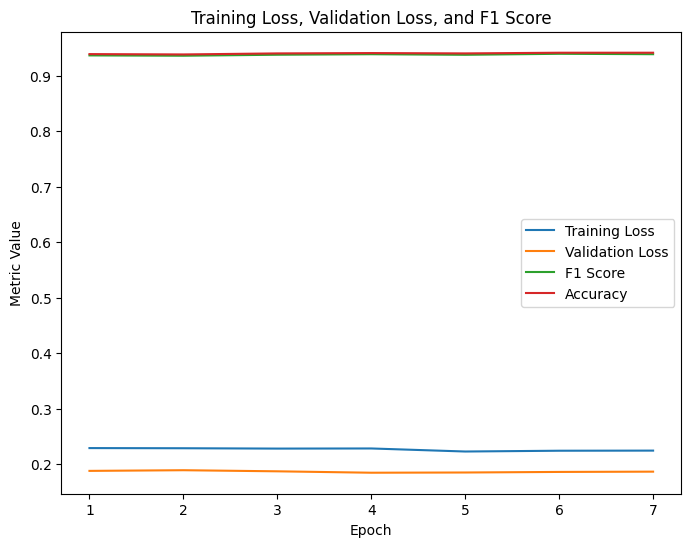

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.228908228568357    0.18783799718401514  0.9363417905293909  0.9386996904024768     0.936868
2                     0.22861927661913364  0.18903799159314003  0.9357528520308592  0.9357528520308592     0.935753
3                     0.22800015765305673  0.1870604576047344   0.9375477249225812  0.9375477249225812     0.937548
4                     0.22822094448936622  0.1845243766438216   0.9384659761470147  0.9384659761470147     0.938466
5                     0.22273616955009298  0.18492728224517502  0.9374366866505746  0.9374366866505746     0.937437
6                     0.22415123874463352  0.1859513771706399   0.9392402531624541  0.9392402531624541     0.93924
7                     0.22436217071389375  0.1864571754940518   0.9385195

In [21]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Convert the multilabel indicator target to numpy array
targets = dataset_train.tensors[1].numpy()

# Initialize lists to store the evaluation metrics for each fold
training_loss_lists = []
validation_loss_lists = []
accuracy_lists = []
precision_lists = []
f1_score_lists = []

# Perform multilabel k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(targets)):
    print(f"\nFold {fold+1}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    dataloader_vals = DataLoader(dataset_train, batch_size=batch_size, sampler=val_sampler)

    # Initialize metrics lists for this fold
    fold_training_loss_list = []
    fold_validation_loss_list = []
    fold_accuracy_list = []
    fold_precision_list = []
    fold_f1_score_list = []

    try:
        fold_training_loss_list, fold_validation_loss_list, fold_accuracy_list, fold_precision_list, fold_f1_score_list = \
        train_model(trainer, dataloader_train, dataloader_vals, epochs, patience)
    except Exception as e:
        print(f"Continue to the next fold {fold+1}: {str(e)}")
        continue

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.2267736110278396
Validation loss: 0.355431347240064
F1 Score (weighted): 0.8907805901316341


Epoch 2:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.22620157434865557
Validation loss: 0.3546186327118875
F1 Score (weighted): 0.8892297658481869
0.25% Training loss decreased compared to the previous epoch
0.23% Validation loss decreased compared to the previous epoch
0.17% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.22676960465015317
Validation loss: 0.3550369518758783
F1 Score (weighted): 0.8907073511532132
0.25% Training loss increased compared to the previous epoch
0.12% Validation loss increased compared to the previous epoch
0.17% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.23033962129657895
Validation loss: 0.3494490566557173
F1 Score (weighted): 0.8911566264794571
1.57% Training loss increased compared to the previous epoch
1.57% Validation loss decreased compared to the previous epoch
0.05% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.22211876794889496
Validation loss: 0.3552388733820951
F1 Score (weighted): 0.8902596002631936
3.57% Training loss decreased compared to the previous epoch
1.66% Validation loss increased compared to the previous epoch
0.1% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.2265480903442949
Validation loss: 0.35622885098673124
F1 Score (weighted): 0.8897867698351555
1.99% Training loss increased compared to the previous epoch
0.28% Validation loss increased compared to the previous epoch
0.05% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/808 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.2250873488616106
Validation loss: 0.35518738040526654
F1 Score (weighted): 0.8898227493431852
0.64% Training loss decreased compared to the previous epoch
0.29% Validation loss decreased compared to the previous epoch
0.0% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 29.362566328048707 minutes
Final Accuracy: 0.8924675324675325
Final Precision: 0.88867552000668


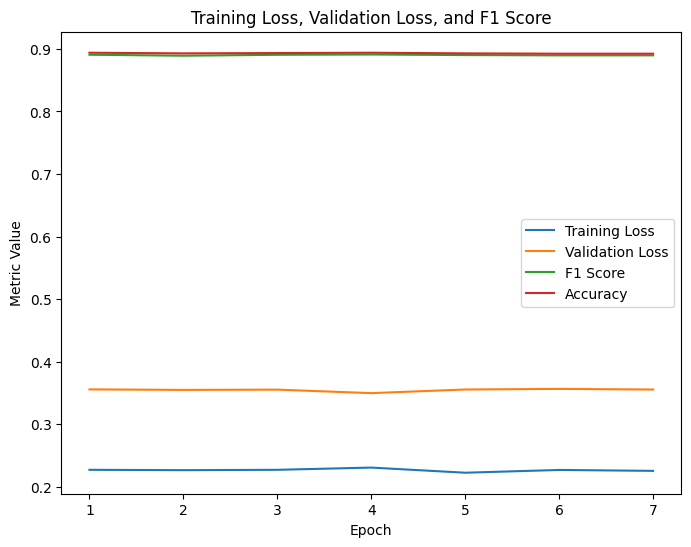

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.2267736110278396   0.355431347240064    0.8907805901316341  0.8940259740259741     0.889302
2                     0.22620157434865557  0.3546186327118875   0.8892297658481869  0.8892297658481869     0.88923
3                     0.22676960465015317  0.3550369518758783   0.8907073511532132  0.8907073511532132     0.890707
4                     0.23033962129657895  0.3494490566557173   0.8911566264794571  0.8911566264794571     0.891157
5                     0.22211876794889496  0.3552388733820951   0.8902596002631936  0.8902596002631936     0.89026
6                     0.2265480903442949   0.35622885098673124  0.8897867698351555  0.8897867698351555     0.889787
7                     0.2250873488616106   0.35518738040526654  0.88982274

([0.2267736110278396,
  0.22620157434865557,
  0.22676960465015317,
  0.23033962129657895,
  0.22211876794889496,
  0.2265480903442949,
  0.2250873488616106],
 [0.355431347240064,
  0.3546186327118875,
  0.3550369518758783,
  0.3494490566557173,
  0.3552388733820951,
  0.35622885098673124,
  0.35518738040526654],
 [0.8940259740259741,
  0.892987012987013,
  0.8935064935064935,
  0.8940259740259741,
  0.892987012987013,
  0.8924675324675325,
  0.8924675324675325],
 [0.8893023973818676,
  0.8875158239532287,
  0.8892982411628642,
  0.8899235131543988,
  0.8888168114288831,
  0.8882572823242679,
  0.88867552000668],
 [0.8907805901316341,
  0.8892297658481869,
  0.8907073511532132,
  0.8911566264794571,
  0.8902596002631936,
  0.8897867698351555,
  0.8898227493431852])

In [22]:
train_model(trainer, dataloader_train, dataloader_val, epochs, patience)